# Time-Varying Selectivity with 2D Autoregressive Structure

Separable AR1 processes in year and age via RTMB

## Overview

In many fisheries, selectivity is not constant over time. Changes in fishing gear, spatial effort allocation, and fish distribution can all shift the age-specific vulnerability pattern across years. A time-varying selectivity model captures these dynamics by allowing log-selectivity deviations to vary over a year $\times$ age matrix, with temporal and ontogenetic smoothness enforced through a separable two-dimensional autoregressive prior.

This formulation uses RTMB’s `dautoreg` and `dseparable` functions to construct a Kronecker-structured precision matrix, providing a computationally efficient and differentiable prior for the year–age deviation surface.

## Model definition

### Selectivity-at-age by year

Let $f$ index fishery, $y$ index year, and $a$ index age. For each fishery, a matrix of log-selectivity deviations $\boldsymbol{\epsilon}_f$ is defined over years $y = 1, \ldots, Y$ and estimated ages $a = a_{\min}, \ldots, a_{\max}$:

$$
\log s_{f,y,a} = \epsilon_{f,y,a}
$$

The realized selectivity is obtained by exponentiating and normalizing so that the mean across ages within each year equals 1:

$$
s_{f,y,a} = \frac{\exp(\epsilon_{f,y,a})}
{\frac{1}{a_{\max} - a_{\min} + 1}\sum_{a'=a_{\min}}^{a_{\max}}
\exp(\epsilon_{f,y,a'})}
$$ For ages beyond $a_{\max}$, selectivity may be held constant at the value for $a_{\max}$ (a “plus-group” extension):

$$
s_{f,y,a} = s_{f,y,a_{\max}}, \qquad a > a_{\max}.
$$

### Block structure for change years

In practice, selectivity is not re-estimated in every year. Instead, **change years** define blocks within which selectivity is constant. Let $\mathbf{C}_f$ be a binary indicator matrix where $C_{f,y} = 1$ if year $y$ starts a new selectivity block for fishery $f$. Within a block, selectivity repeats the values from the block’s initial year:

$$
s_{f,y,a} =
\begin{cases}
s_{f,y,a} & \text{if } C_{f,y} = 1 \\
s_{f,y-1,a} & \text{if } C_{f,y} = 0
\end{cases}
$$

This reduces the number of free parameters from $Y \times (a_{\max} - a_{\min} + 1)$ to $B_f \times (a_{\max} - a_{\min} + 1)$ where $B_f$ is the number of selectivity blocks for fishery $f$.

## Separable 2D AR1 prior

### Marginal AR1 processes

The log-selectivity deviations for each fishery are assumed to follow a separable two-dimensional Gaussian Markov random field (GMRF). The key idea is that temporal (year) and ontogenetic (age) correlation structures are modeled independently, and their joint distribution is constructed via a Kronecker product.

Define two stationary AR1 processes:

**Year dimension.** For a sequence $x_1, \ldots, x_Y$:

$$
x_y = \rho_y\, x_{y-1} + \sigma_y\,\eta_y, \qquad \eta_y \sim \mathcal{N}(0,1)
$$

where $\rho_y \in (-1, 1)$ is the year-to-year autocorrelation. The marginal variance is $\sigma_y^2 / (1 - \rho_y^2)$ and the precision (inverse covariance) matrix for a length-$Y$ sequence is the tridiagonal matrix $\mathbf{Q}_y$ with:

$$
[\mathbf{Q}_y]_{ij} =
\begin{cases}
1 + \rho_y^2 & i = j,\ 1 < i < Y \\
1 & i = j = 1 \text{ or } i = j = Y \\
-\rho_y & |i - j| = 1 \\
0 & \text{otherwise}
\end{cases}
$$

scaled by $1 / \sigma_y^2$.

**Age dimension.** Analogously, for ages $a_{\min}, \ldots, a_{\max}$:

$$
z_a = \rho_a\, z_{a-1} + \sigma_a\,\nu_a, \qquad \nu_a \sim \mathcal{N}(0,1)
$$

with autocorrelation $\rho_a$ and precision matrix $\mathbf{Q}_a$ of the same tridiagonal form.

### Kronecker product structure

The joint precision matrix for the vectorized year–age deviation $\text{vec}(\boldsymbol{\epsilon}_f)$ is the Kronecker product:

$$
\mathbf{Q} = \mathbf{Q}_y \otimes \mathbf{Q}_a
$$

This encodes the assumption that the year and age correlation structures are **separable**: the correlation between $\epsilon_{y,a}$ and $\epsilon_{y',a'}$ factorizes as

$$
\text{Cor}(\epsilon_{y,a},\, \epsilon_{y',a'}) = \rho_y^{|y - y'|}\,\rho_a^{|a - a'|}
$$

The corresponding joint covariance matrix is:

$$
\boldsymbol{\Sigma} = \boldsymbol{\Sigma}_y \otimes \boldsymbol{\Sigma}_a
$$

where $\boldsymbol{\Sigma}_y$ and $\boldsymbol{\Sigma}_a$ are the marginal AR1 covariance matrices for year and age, respectively.

### Marginal scale

The overall marginal standard deviation of any single element $\epsilon_{f,y,a}$ is

$$
\text{SD}(\epsilon_{f,y,a}) = \frac{\sigma_f}
{\sqrt{1 - \rho_{y,f}^2}\;\sqrt{1 - \rho_{a,f}^2}}
$$

where $\sigma_f$ is the innovation scale for fishery $f$. This quantity (`scale` in the RTMB code) ensures that the specified $\sigma_f$ represents the innovation standard deviation while the marginal variance accounts for both autocorrelation parameters.

### Log-density

The log-density of the separable GMRF, evaluated by RTMB’s `dseparable`, is:

$$
\log p(\boldsymbol{\epsilon}_f \mid \rho_y, \rho_a, \sigma) =
-\frac{YA}{2}\log(2\pi)
+ \frac{A}{2}\log|\mathbf{Q}_y|
+ \frac{Y}{2}\log|\mathbf{Q}_a|
- \frac{1}{2}\,\text{vec}(\boldsymbol{\epsilon}_f)^\top
\left(\mathbf{Q}_y \otimes \mathbf{Q}_a\right)
\text{vec}(\boldsymbol{\epsilon}_f)
$$

where $A = a_{\max} - a_{\min} + 1$ is the number of estimated ages. The Kronecker structure means the log-determinant decomposes as a sum of the individual log-determinants (scaled by dimension), and the quadratic form can be evaluated without materializing the full $YA \times YA$ precision matrix.

## RTMB implementation

The implementation uses `dseparable` to compose two `dautoreg` densities. The `dautoreg(x, phi)` function evaluates the log-density of an AR1 process with autocorrelation `phi`, and `dseparable(f1, f2)` constructs their Kronecker product density.

In [ ]:
library(RTMB)

get_selectivity_prior <- function(rho_y, rho_a, log_sigma, par_log_sel_fya) {
  n_sel <- length(par_log_sel_fya)
  lp_sel <- numeric(n_sel)
  for (f in seq_len(n_sel)) {
    # Marginal scale: sigma / sqrt((1-rho_y^2)(1-rho_a^2))
    scale <- exp(log_sigma[f]) /
      sqrt(1 - rho_y[f]^2) /
      sqrt(1 - rho_a[f]^2)

    # AR1 density in year dimension
    f1 <- function(x) dautoreg(x, phi = rho_y[f], log = TRUE)
    # AR1 density in age dimension
    f2 <- function(x) dautoreg(x, phi = rho_a[f], log = TRUE)

    # Separable 2D density via Kronecker product
    lp_sel[f] <- -dseparable(f1, f2)(
      par_log_sel_fya[[f]],
      scale = scale
    )
  }
  return(lp_sel)
}


### `dseparable` mechanics

The call `dseparable(f1, f2)(X, scale)` performs the following:

1.  Treats the matrix `X` (dimension $B_f \times A$) as a 2D random field.
2.  Evaluates `f1` along each row (year marginal) and `f2` along each column (age marginal).
3.  Combines them via the Kronecker identity to compute the joint log-density without forming the full $B_f A \times B_f A$ precision matrix.
4.  The `scale` parameter rescales the entire field so that the marginal standard deviation matches the specified value.

This is efficient because the computational cost scales as $\mathcal{O}(B_f \cdot A)$ rather than $\mathcal{O}((B_f \cdot A)^3)$.

### Selectivity construction

The `get_selectivity` function builds the full 3D array (fishery $\times$ year $\times$ age) from the estimated log-selectivity blocks:

In [ ]:
get_selectivity <- function(n_age, max_age, first_yr, first_yr_catch,
                            sel_min_age_f, sel_max_age_f, sel_end_f,
                            sel_change_year_fy, par_log_sel) {
  n_sel  <- nrow(sel_change_year_fy)
  n_year <- ncol(sel_change_year_fy)
  ymin   <- first_yr_catch - first_yr + 1
  sel_fya <- array(0, dim = c(n_sel, n_year, n_age))

  for (f in seq_len(n_sel)) {
    amin <- sel_min_age_f[f] + 1
    amax <- sel_max_age_f[f] + 1
    ipar <- 1
    for (y in ymin:n_year) {
      if (sel_change_year_fy[f, y] != 0) {
        # New selectivity block: exponentiate and mean-normalize
        sel_tmp <- exp(par_log_sel[[f]][ipar, ])
        ipar <- ipar + 1
        sel_fya[f, y, amin:amax] <- sel_tmp / mean(sel_tmp)
        # Extend to plus group if needed
        if (as.logical(sel_end_f[f]) && amax < max_age) {
          for (a in (amax + 1):n_age) {
            sel_fya[f, y, a] <- sel_fya[f, y, amax]
          }
        }
      } else {
        # Carry forward previous block
        sel_fya[f, y, ] <- sel_fya[f, y - 1, ]
      }
    }
  }
  return(sel_fya)
}


## Visualization


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

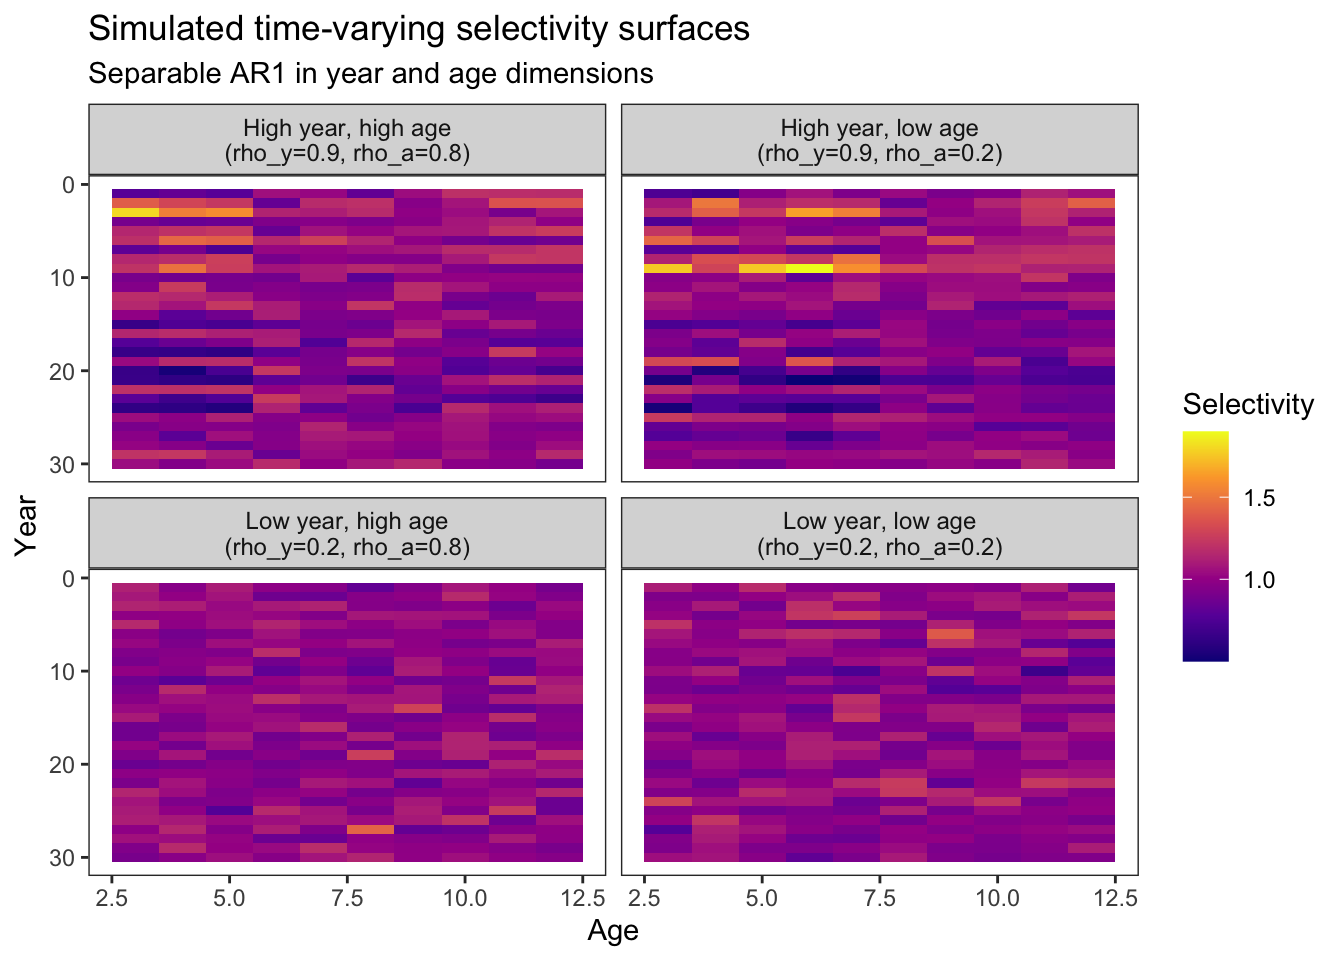

In [ ]:
library(ggplot2)
library(dplyr)


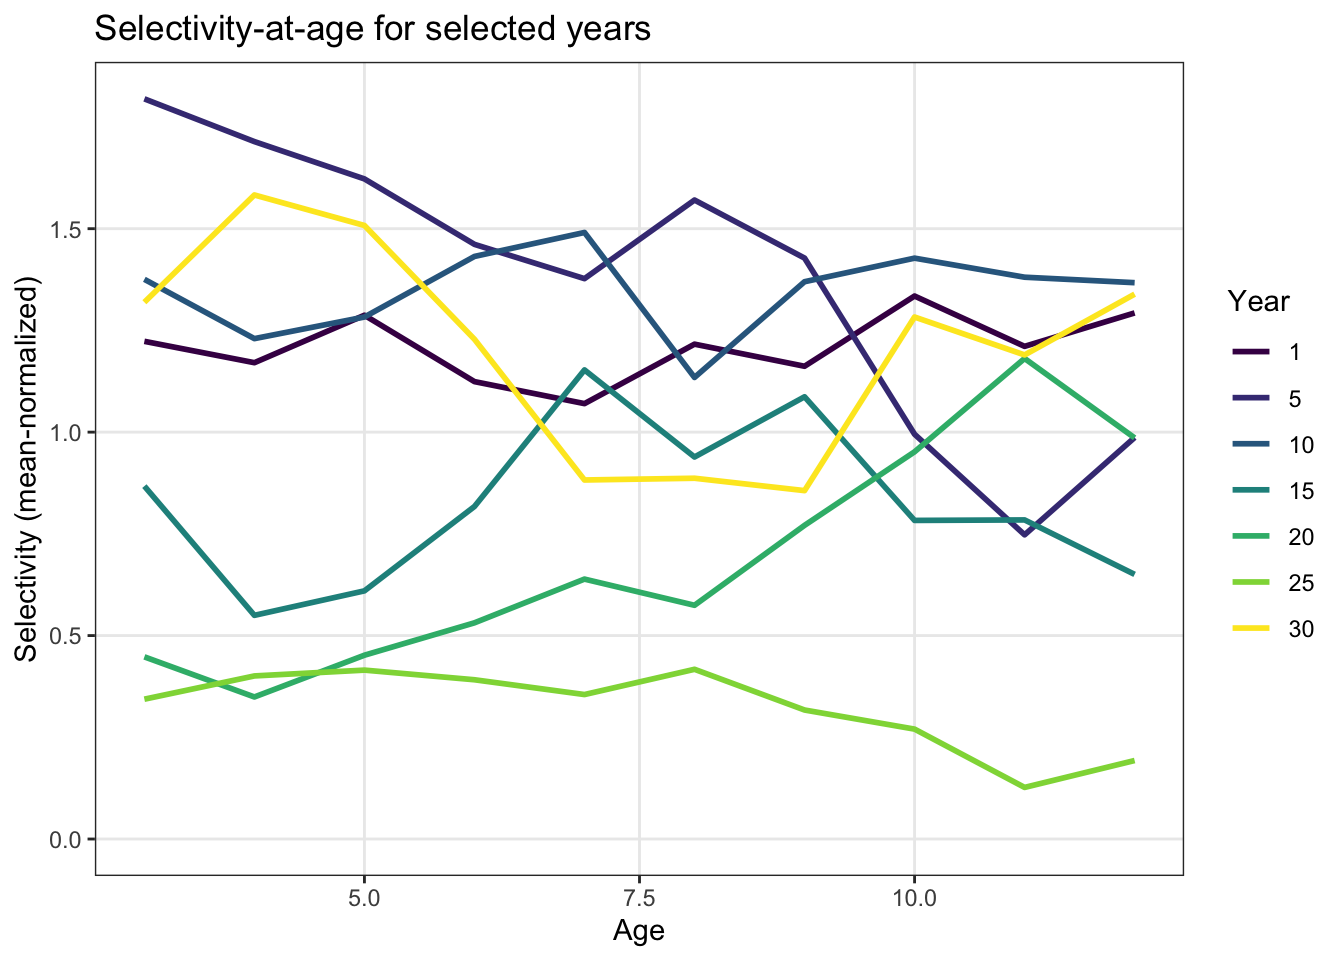

In [ ]:
sel_mat <- sim_ar1_2d(n_year, n_age, rho_y = 0.9, rho_a = 0.8, sigma = 0.3)
sel_df <- expand_grid(year = 1:n_year, age_idx = 1:n_age) %>%
  mutate(
    age = ages[age_idx],
    selectivity = as.vector(sel_mat)
  ) %>%
  filter(year %in% c(1, 5, 10, 15, 20, 25, 30))

ggplot(sel_df, aes(x = age, y = selectivity, color = factor(year))) +
  geom_line(linewidth = 1) +
  scale_color_viridis_d(name = "Year", option = "D") +
  scale_y_continuous(limits = c(0, NA)) +
  labs(x = "Age", y = "Selectivity (mean-normalized)",
       title = "Selectivity-at-age for selected years") +
  theme_bw(base_size = 11) +
  theme(panel.grid.minor = element_blank())


## Properties and considerations

The separable 2D AR1 formulation has several properties that make it attractive for operational stock assessments:

**Parsimony.** Three hyperparameters per fishery ($\rho_y$, $\rho_a$, $\sigma$) control the smoothness of an arbitrarily large year–age surface. The autocorrelation parameters shrink the effective number of free parameters well below the nominal $B_f \times A$.

**Computational efficiency.** The Kronecker structure avoids forming or factorizing the full joint precision matrix. Combined with RTMB’s automatic differentiation, gradients of the log-prior are computed at the same $\mathcal{O}(B_f \cdot A)$ cost as the density itself.

**Interpretability.** The parameter $\rho_y$ directly controls how quickly selectivity can change between years (high values produce slow drift, low values allow abrupt shifts), while $\rho_a$ controls the smoothness of the selectivity curve within any single year.

**Integration with block structure.** The change-year mechanism can be layered on top: the 2D AR1 prior applies to the matrix of block-specific selectivity patterns, not to every individual year. This reduces dimensionality further while still allowing the prior to borrow strength across blocks.

```` markdown
---
title: "Time-Varying Selectivity with 2D Autoregressive Structure"
subtitle: "Separable AR1 processes in year and age via RTMB"
---

## Overview

In many fisheries, selectivity is not constant over time. Changes in fishing
gear, spatial effort allocation, and fish distribution can all shift the
age-specific vulnerability pattern across years. A time-varying selectivity
model captures these dynamics by allowing log-selectivity deviations to vary
over a year $\times$ age matrix, with temporal and ontogenetic smoothness
enforced through a separable two-dimensional autoregressive prior.

This formulation uses RTMB's `dautoreg` and `dseparable` functions to construct
a Kronecker-structured precision matrix, providing a computationally efficient
and differentiable prior for the year--age deviation surface.

## Model definition

### Selectivity-at-age by year

Let $f$ index fishery, $y$ index year, and $a$ index age. For each fishery, a
matrix of log-selectivity deviations $\boldsymbol{\epsilon}_f$ is defined over
years $y = 1, \ldots, Y$ and estimated ages $a = a_{\min}, \ldots, a_{\max}$:

$$
\log s_{f,y,a} = \epsilon_{f,y,a}
$$

The realized selectivity is obtained by exponentiating and normalizing so that
the mean across ages within each year equals 1:

$$
s_{f,y,a} = \frac{\exp(\epsilon_{f,y,a})}
{\frac{1}{a_{\max} - a_{\min} + 1}\sum_{a'=a_{\min}}^{a_{\max}}
\exp(\epsilon_{f,y,a'})}
$$
For ages beyond $a_{\max}$, selectivity may be held constant at the value for
$a_{\max}$ (a "plus-group" extension):

$$
s_{f,y,a} = s_{f,y,a_{\max}}, \qquad a > a_{\max}.
$$

### Block structure for change years

In practice, selectivity is not re-estimated in every year. Instead,
**change years** define blocks within which selectivity is constant. Let
$\mathbf{C}_f$ be a binary indicator matrix where $C_{f,y} = 1$ if year $y$
starts a new selectivity block for fishery $f$. Within a block, selectivity
repeats the values from the block's initial year:

$$
s_{f,y,a} =
\begin{cases}
s_{f,y,a} & \text{if } C_{f,y} = 1 \\
s_{f,y-1,a} & \text{if } C_{f,y} = 0
\end{cases}
$$

This reduces the number of free parameters from $Y \times (a_{\max} - a_{\min} + 1)$
to $B_f \times (a_{\max} - a_{\min} + 1)$ where $B_f$ is the number of
selectivity blocks for fishery $f$.

## Separable 2D AR1 prior

### Marginal AR1 processes

The log-selectivity deviations for each fishery are assumed to follow a
separable two-dimensional Gaussian Markov random field (GMRF). The key idea is
that temporal (year) and ontogenetic (age) correlation structures are modeled
independently, and their joint distribution is constructed via a Kronecker
product.

Define two stationary AR1 processes:

**Year dimension.** For a sequence $x_1, \ldots, x_Y$:

$$
x_y = \rho_y\, x_{y-1} + \sigma_y\,\eta_y, \qquad \eta_y \sim \mathcal{N}(0,1)
$$

where $\rho_y \in (-1, 1)$ is the year-to-year autocorrelation. The marginal
variance is $\sigma_y^2 / (1 - \rho_y^2)$ and the precision (inverse
covariance) matrix for a length-$Y$ sequence is the tridiagonal matrix
$\mathbf{Q}_y$ with:

$$
[\mathbf{Q}_y]_{ij} =
\begin{cases}
1 + \rho_y^2 & i = j,\ 1 < i < Y \\
1 & i = j = 1 \text{ or } i = j = Y \\
-\rho_y & |i - j| = 1 \\
0 & \text{otherwise}
\end{cases}
$$

scaled by $1 / \sigma_y^2$.

**Age dimension.** Analogously, for ages $a_{\min}, \ldots, a_{\max}$:

$$
z_a = \rho_a\, z_{a-1} + \sigma_a\,\nu_a, \qquad \nu_a \sim \mathcal{N}(0,1)
$$

with autocorrelation $\rho_a$ and precision matrix $\mathbf{Q}_a$ of the same
tridiagonal form.

### Kronecker product structure

The joint precision matrix for the vectorized year--age deviation
$\text{vec}(\boldsymbol{\epsilon}_f)$ is the Kronecker product:

$$
\mathbf{Q} = \mathbf{Q}_y \otimes \mathbf{Q}_a
$$

This encodes the assumption that the year and age correlation structures are
**separable**: the correlation between $\epsilon_{y,a}$ and $\epsilon_{y',a'}$
factorizes as

$$
\text{Cor}(\epsilon_{y,a},\, \epsilon_{y',a'}) = \rho_y^{|y - y'|}\,\rho_a^{|a - a'|}
$$

The corresponding joint covariance matrix is:

$$
\boldsymbol{\Sigma} = \boldsymbol{\Sigma}_y \otimes \boldsymbol{\Sigma}_a
$$

where $\boldsymbol{\Sigma}_y$ and $\boldsymbol{\Sigma}_a$ are the marginal
AR1 covariance matrices for year and age, respectively.

### Marginal scale

The overall marginal standard deviation of any single element
$\epsilon_{f,y,a}$ is

$$
\text{SD}(\epsilon_{f,y,a}) = \frac{\sigma_f}
{\sqrt{1 - \rho_{y,f}^2}\;\sqrt{1 - \rho_{a,f}^2}}
$$

where $\sigma_f$ is the innovation scale for fishery $f$. This quantity
(`scale` in the RTMB code) ensures that the specified $\sigma_f$ represents
the innovation standard deviation while the marginal variance accounts for
both autocorrelation parameters.

### Log-density

The log-density of the separable GMRF, evaluated by RTMB's `dseparable`, is:

$$
\log p(\boldsymbol{\epsilon}_f \mid \rho_y, \rho_a, \sigma) =
-\frac{YA}{2}\log(2\pi)
+ \frac{A}{2}\log|\mathbf{Q}_y|
+ \frac{Y}{2}\log|\mathbf{Q}_a|
- \frac{1}{2}\,\text{vec}(\boldsymbol{\epsilon}_f)^\top
\left(\mathbf{Q}_y \otimes \mathbf{Q}_a\right)
\text{vec}(\boldsymbol{\epsilon}_f)
$$

where $A = a_{\max} - a_{\min} + 1$ is the number of estimated ages. The
Kronecker structure means the log-determinant decomposes as a sum of the
individual log-determinants (scaled by dimension), and the quadratic form can
be evaluated without materializing the full $YA \times YA$ precision matrix.

## RTMB implementation

The implementation uses `dseparable` to compose two `dautoreg` densities. The
`dautoreg(x, phi)` function evaluates the log-density of an AR1 process with
autocorrelation `phi`, and `dseparable(f1, f2)` constructs their Kronecker
product density.

```{r rtmb-code}
#| eval: false
#| echo: true
library(RTMB)

get_selectivity_prior <- function(rho_y, rho_a, log_sigma, par_log_sel_fya) {
  n_sel <- length(par_log_sel_fya)
  lp_sel <- numeric(n_sel)
  for (f in seq_len(n_sel)) {
    # Marginal scale: sigma / sqrt((1-rho_y^2)(1-rho_a^2))
    scale <- exp(log_sigma[f]) /
      sqrt(1 - rho_y[f]^2) /
      sqrt(1 - rho_a[f]^2)

    # AR1 density in year dimension
    f1 <- function(x) dautoreg(x, phi = rho_y[f], log = TRUE)
    # AR1 density in age dimension
    f2 <- function(x) dautoreg(x, phi = rho_a[f], log = TRUE)

    # Separable 2D density via Kronecker product
    lp_sel[f] <- -dseparable(f1, f2)(
      par_log_sel_fya[[f]],
      scale = scale
    )
  }
  return(lp_sel)
}
```

### `dseparable` mechanics

The call `dseparable(f1, f2)(X, scale)` performs the following:

1. Treats the matrix `X` (dimension $B_f \times A$) as a 2D random field.
2. Evaluates `f1` along each row (year marginal) and `f2` along each column
   (age marginal).
3. Combines them via the Kronecker identity to compute the joint log-density
   without forming the full $B_f A \times B_f A$ precision matrix.
4. The `scale` parameter rescales the entire field so that the marginal
   standard deviation matches the specified value.

This is efficient because the computational cost scales as
$\mathcal{O}(B_f \cdot A)$ rather than $\mathcal{O}((B_f \cdot A)^3)$.

### Selectivity construction

The `get_selectivity` function builds the full 3D array (fishery $\times$
year $\times$ age) from the estimated log-selectivity blocks:

```{r get-sel-code}
#| eval: false
#| echo: true
get_selectivity <- function(n_age, max_age, first_yr, first_yr_catch,
                            sel_min_age_f, sel_max_age_f, sel_end_f,
                            sel_change_year_fy, par_log_sel) {
  n_sel  <- nrow(sel_change_year_fy)
  n_year <- ncol(sel_change_year_fy)
  ymin   <- first_yr_catch - first_yr + 1
  sel_fya <- array(0, dim = c(n_sel, n_year, n_age))

  for (f in seq_len(n_sel)) {
    amin <- sel_min_age_f[f] + 1
    amax <- sel_max_age_f[f] + 1
    ipar <- 1
    for (y in ymin:n_year) {
      if (sel_change_year_fy[f, y] != 0) {
        # New selectivity block: exponentiate and mean-normalize
        sel_tmp <- exp(par_log_sel[[f]][ipar, ])
        ipar <- ipar + 1
        sel_fya[f, y, amin:amax] <- sel_tmp / mean(sel_tmp)
        # Extend to plus group if needed
        if (as.logical(sel_end_f[f]) && amax < max_age) {
          for (a in (amax + 1):n_age) {
            sel_fya[f, y, a] <- sel_fya[f, y, amax]
          }
        }
      } else {
        # Carry forward previous block
        sel_fya[f, y, ] <- sel_fya[f, y - 1, ]
      }
    }
  }
  return(sel_fya)
}
```

## Visualization

```{r sim-2d-ar1}
#| label: fig-tv-sim
#| fig-cap: "Simulated 2D AR1 selectivity surfaces under different autocorrelation settings."
library(ggplot2)
library(dplyr)
library(tidyr)

sim_ar1_2d <- function(n_year, n_age, rho_y, rho_a, sigma, seed = 42) {
  set.seed(seed)
  # Simulate AR1 in year
  y_proc <- numeric(n_year)
  y_proc[1] <- rnorm(1, 0, sigma / sqrt(1 - rho_y^2))
  for (t in 2:n_year) {
    y_proc[t] <- rho_y * y_proc[t - 1] + rnorm(1, 0, sigma)
  }
  # Simulate AR1 in age
  a_proc <- numeric(n_age)
  a_proc[1] <- rnorm(1, 0, sigma / sqrt(1 - rho_a^2))
  for (a in 2:n_age) {
    a_proc[a] <- rho_a * a_proc[a - 1] + rnorm(1, 0, sigma)
  }
  # Separable: outer product + noise
  eps <- outer(y_proc, a_proc) +
    matrix(rnorm(n_year * n_age, 0, sigma * 0.3), n_year, n_age)
  # Normalize each year
  sel <- t(apply(eps, 1, function(x) {
    ex <- exp(x)
    ex / mean(ex)
  }))
  sel
}

scenarios <- list(
  list(label = "High year, high age\n(rho_y=0.9, rho_a=0.8)",
       rho_y = 0.9, rho_a = 0.8, sigma = 0.3),
  list(label = "High year, low age\n(rho_y=0.9, rho_a=0.2)",
       rho_y = 0.9, rho_a = 0.2, sigma = 0.3),
  list(label = "Low year, high age\n(rho_y=0.2, rho_a=0.8)",
       rho_y = 0.2, rho_a = 0.8, sigma = 0.3),
  list(label = "Low year, low age\n(rho_y=0.2, rho_a=0.2)",
       rho_y = 0.2, rho_a = 0.2, sigma = 0.3)
)

n_year <- 30
n_age <- 10
ages <- 3:12

all_data <- bind_rows(lapply(seq_along(scenarios), function(i) {
  sc <- scenarios[[i]]
  sel <- sim_ar1_2d(n_year, n_age, sc$rho_y, sc$rho_a, sc$sigma, seed = i)
  expand_grid(year = 1:n_year, age_idx = 1:n_age) %>%
    mutate(
      age = ages[age_idx],
      selectivity = as.vector(sel),
      scenario = sc$label
    )
}))

ggplot(all_data, aes(x = age, y = year, fill = selectivity)) +
  geom_tile() +
  facet_wrap(~scenario, ncol = 2) +
  scale_fill_viridis_c(name = "Selectivity", option = "C") +
  scale_y_reverse() +
  labs(x = "Age", y = "Year",
       title = "Simulated time-varying selectivity surfaces",
       subtitle = "Separable AR1 in year and age dimensions") +
  theme_bw(base_size = 11) +
  theme(panel.grid = element_blank(),
        strip.text = element_text(size = 9))
```

```{r sim-line-plot}
#| label: fig-tv-lines
#| fig-cap: "Time-varying selectivity curves at selected years (high autocorrelation scenario)."
sel_mat <- sim_ar1_2d(n_year, n_age, rho_y = 0.9, rho_a = 0.8, sigma = 0.3)
sel_df <- expand_grid(year = 1:n_year, age_idx = 1:n_age) %>%
  mutate(
    age = ages[age_idx],
    selectivity = as.vector(sel_mat)
  ) %>%
  filter(year %in% c(1, 5, 10, 15, 20, 25, 30))

ggplot(sel_df, aes(x = age, y = selectivity, color = factor(year))) +
  geom_line(linewidth = 1) +
  scale_color_viridis_d(name = "Year", option = "D") +
  scale_y_continuous(limits = c(0, NA)) +
  labs(x = "Age", y = "Selectivity (mean-normalized)",
       title = "Selectivity-at-age for selected years") +
  theme_bw(base_size = 11) +
  theme(panel.grid.minor = element_blank())
```

## Properties and considerations

The separable 2D AR1 formulation has several properties that make it attractive
for operational stock assessments:

**Parsimony.** Three hyperparameters per fishery ($\rho_y$, $\rho_a$, $\sigma$)
control the smoothness of an arbitrarily large year--age surface. The
autocorrelation parameters shrink the effective number of free parameters well
below the nominal $B_f \times A$.

**Computational efficiency.** The Kronecker structure avoids forming or
factorizing the full joint precision matrix. Combined with RTMB's automatic
differentiation, gradients of the log-prior are computed at the same
$\mathcal{O}(B_f \cdot A)$ cost as the density itself.

**Interpretability.** The parameter $\rho_y$ directly controls how quickly
selectivity can change between years (high values produce slow drift, low
values allow abrupt shifts), while $\rho_a$ controls the smoothness of the
selectivity curve within any single year.

**Integration with block structure.** The change-year mechanism can be layered
on top: the 2D AR1 prior applies to the matrix of block-specific selectivity
patterns, not to every individual year. This reduces dimensionality further
while still allowing the prior to borrow strength across blocks.
````